<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

### Load and filter data

In [175]:
#Start Here
# for loading data
import pandas as pd

# for tokenization
import spacy
from collections import Counter

# for building LDA model
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

# for printing topics in a readable manner
import re

# for visuzlization
import pyLDAvis.gensim

# for computing coherence
from gensim.models.coherencemodel import CoherenceModel

# for visualizing coherence 
import seaborn as sns

In [9]:

df0 = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [10]:
df0.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [27]:
df = df0.copy()[['primaryCategories',  'reviews.text']]

In [29]:
pd.set_option('display.max_colwidth', 100)
df.head(20)

,primaryCategories,reviews.text
0,Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...
1,Health & Beauty,Bulk is always the less expensive way to go for products like these
2,Health & Beauty,Well they are not Duracell but for the price i am happy.
3,Health & Beauty,Seem to work as well as name brand batteries at a much better price
4,Health & Beauty,These batteries are very long lasting the price is great.
5,Health & Beauty,Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noti...
6,Health & Beauty,ive not had any problame with these batteries have ordered them in the past been very pleased.
7,Health & Beauty,Well if you are looking for cheap non-rechargeable batteries that last quite a while then these ...
8,Health & Beauty,"These do not hold the amount of high power juice like energizer or duracell, but they are half t..."
9,Health & Beauty,AmazonBasics AA AAA batteries have done well by me appear to have a good shelf life. I'll buy th...


In [35]:
df['primaryCategories'].value_counts(sort = True)

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [42]:
subject = "Health & Beauty"
df = df[df['primaryCategories'] == subject]

In [45]:
df.head()

,primaryCategories,reviews.text
0,Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...
1,Health & Beauty,Bulk is always the less expensive way to go for products like these
2,Health & Beauty,Well they are not Duracell but for the price i am happy.
3,Health & Beauty,Seem to work as well as name brand batteries at a much better price
4,Health & Beauty,These batteries are very long lasting the price is great.


In [47]:
df = df.drop(["primaryCategories"], axis = 1)
df.head()

,reviews.text
0,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put ...
1,Bulk is always the less expensive way to go for products like these
2,Well they are not Duracell but for the price i am happy.
3,Seem to work as well as name brand batteries at a much better price
4,These batteries are very long lasting the price is great.


In [52]:
# We have our filtered dataframe now. 

# We can do one last check to see if the size matches up with the value counts of the number of rows for the category

df.shape

(12071, 1)

### Tokenize data

In [171]:
# get our pre-trained spacy neural network for lemmatization
nlp = spacy.load("en_core_web_lg")

In [ ]:
#new_stop_words = ['battery', 'amazon', 'use']

#STOPS = nlp.Defaults.stop_words.union(new_stop_words)

In [75]:
# we will create a list of lists of tokens so we can input into gensim

word_counts = Counter()
tokens = []

for doc in nlp.pipe(df['reviews.text']):

    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop != True) and (token.pos_ != 'PRON')) and (token.is_punct !=True):
            token = token.lemma_.strip()
            doc_tokens.append(token)
            word_counts[token]+=1
    
    tokens.append(doc_tokens)

In [79]:
# Check to make sure the length is the same as df.shape

len(tokens) == df.shape[0]

True

In [80]:
tokens[0]

['order',
 '3',
 'item',
 'bad',
 'quality',
 'miss',
 'backup',
 'spring',
 'pc',
 'aluminum',
 'battery',
 'work']

In [82]:
# Let's take a look at the most common words
# Consider adding to stop words

word_counts.most_common(10)

[('battery', 9255),
 ('great', 3828),
 ('good', 3468),
 ('price', 3205),
 ('work', 2770),
 ('brand', 2200),
 ('long', 2116),
 ('buy', 1970),
 ('Amazon', 1286),
 ('use', 986)]

### Create Gensim LDA Topic Model

In [90]:
# "fit" 
id2word = corpora.Dictionary(tokens)

In [101]:
i = 0
for entry in id2word:
    print(entry, id2word[entry])
    i+=1
    if i >= 20:
        break

0 3
1 aluminum
2 backup
3 bad
4 battery
5 item
6 miss
7 order
8 pc
9 quality
10 spring
11 work
12 bulk
13 expensive
14 like
15 product
16 way
17 Duracell
18 happy
19 price


In [102]:
len(id2word.keys())

5248

In [103]:
# Filter down the extremes
id2word.filter_extremes(no_below=5, no_above=.95)

In [105]:
len(id2word.keys())

1415

In [136]:
# create our matrix that we'll input into the model
# I think it's just a frequency matrix
corpus = [id2word.doc2bow(doc) for doc in tokens]

In [137]:
len(corpus)

12071

In [139]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [140]:
# Generate model
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=10, 
                  passes=100)

In [141]:
lda.print_topics()

[(0,
  '0.334*"good" + 0.101*"battery" + 0.090*"price" + 0.074*"work" + 0.053*"far" + 0.037*"quality" + 0.034*"excellent" + 0.031*"product" + 0.023*"love" + 0.020*"buy"'),
 (1,
  '0.082*"battery" + 0.079*"Amazon" + 0.056*"order" + 0.041*"thank" + 0.035*"buy" + 0.031*"cheap" + 0.025*"time" + 0.018*"quality" + 0.015*"super" + 0.014*"advertise"'),
 (2,
  '0.091*"battery" + 0.073*"deal" + 0.072*"good" + 0.051*"brand" + 0.041*"long" + 0.036*"Duracell" + 0.033*"well" + 0.028*"price" + 0.022*"cost" + 0.016*"energizer"'),
 (3,
  '0.061*"box" + 0.060*"battery" + 0.056*"package" + 0.053*"come" + 0.039*"packaging" + 0.034*"nice" + 0.029*"easy" + 0.027*"ok" + 0.019*"open" + 0.019*"fast"'),
 (4,
  '0.091*"battery" + 0.023*"use" + 0.016*"week" + 0.016*"month" + 0.014*"2" + 0.013*"light" + 0.013*"day" + 0.013*"remote" + 0.013*"buy" + 0.013*"Amazon"'),
 (5,
  '0.135*"battery" + 0.094*"brand" + 0.047*"price" + 0.041*"long" + 0.037*"buy" + 0.024*"work" + 0.022*"Amazon" + 0.019*"cheap" + 0.016*"store" + 

In [142]:
# print the topics in a readable manner
words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
good battery price work far

------ Topic 1 ------
battery Amazon order thank buy

------ Topic 2 ------
battery deal good brand long

------ Topic 3 ------
box battery package come packaging

------ Topic 4 ------
battery use week month 2

------ Topic 5 ------
battery brand price long buy

------ Topic 6 ------
battery money life work like

------ Topic 7 ------
great price battery work value

------ Topic 8 ------
battery expect purchase work product

------ Topic 9 ------
battery need use toy buy



### Visualize Results

In [143]:
pyLDAvis.enable_notebook()

In [144]:
pyLDAvis.gensim.prepare(lda,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.168392  0.095770       1        1  18.370701
5      0.041943  0.091765       2        1  16.021786
9     -0.108287  0.058280       3        1  13.852226
7      0.264945 -0.075190       4        1   9.155677
2      0.116319  0.068752       5        1   8.761871
0      0.258502 -0.067392       6        1   7.850523
8     -0.072510  0.079462       7        1   7.337670
3     -0.176499 -0.346849       8        1   6.820713
1     -0.079628  0.072505       9        1   6.114483
6     -0.076395  0.022897      10        1   5.714352, topic_info=         Term         Freq        Total Category  logprob  loglift
19      great  3492.000000  3492.000000  Default  30.0000  30.0000
30       good  3203.000000  3203.000000  Default  29.0000  29.0000
16      price  2993.000000  2993.000000  Default  28.0000  28.0000
17      brand  2157.000000  2157.000000  Default  27.0000  27.0000
22     Amazon  1297.000000  1297.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
20       last    45.226784   551.529541  Topic10  -4.8096   0.3612
130       box    40.056065   474.063965  Topic10  -4.9310   0.3911
98       know    37.029949   241.085907  Topic10  -5.0095   0.9888
35   purchase    38.345562   712.180969  Topic10  -4.9746  -0.0595
17      brand    39.622311  2157.924561  Topic10  -4.9419  -1.1353

[654 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
342       1  0.911946     1
342       5  0.026433     1
342       7  0.039650     1
1381      2  0.911868   1/3
1251      7  0.855321    13
...     ...       ...   ...
90        9  0.091902  year
90       10  0.194833  year
896       2  0.941160   yup
1105      2  0.059763  zero
1105     10  0.896438  zero

[1264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 10, 8, 3, 1, 9, 4, 2, 7])

In [146]:
# store our data in aa dataframe
distro = [lda[d] for d in corpus]

In [155]:
def update(doc):
        d_dist = {k:0 for k in range(0, len(lda.get_topics()))}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [157]:
doc_topics = pd.DataFrame.from_records(new_distro)
doc_topics.columns = topics
doc_topics.head()

,good battery price work far,battery Amazon order thank buy,battery deal good brand long,box battery package come packaging,battery use week month 2,battery brand price long buy,battery money life work like,great price battery work value,battery expect purchase work product,battery need use toy buy
0,0.010005,0.010008,0.010002,0.010002,0.139720,0.010003,0.010003,0.010005,0.780244,0.010006
1,0.016674,0.016673,0.016668,0.016671,0.016669,0.849953,0.016672,0.016674,0.016674,0.016672
2,0.025015,0.025001,0.524953,0.025002,0.025001,0.025011,0.025003,0.025024,0.274988,0.025002
3,0.016673,0.016667,0.016674,0.016667,0.016668,0.849969,0.016669,0.016674,0.016669,0.016669
4,0.016669,0.016668,0.016669,0.016668,0.016669,0.016671,0.016669,0.849982,0.016668,0.016668


In [158]:
doc_topics['primary_topic'] = doc_topics.idxmax(axis=1)

In [163]:
doc_topics['primary_topic'].value_counts()

great price battery work value          2317
good battery price work far             2069
battery brand price long buy            1871
battery need use toy buy                1131
battery use week month 2                1131
battery deal good brand long             998
battery Amazon order thank buy           691
battery expect purchase work product     670
box battery package come packaging       651
battery money life work like             542
Name: primary_topic, dtype: int64

### Compute Coherence

In [164]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [169]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=10)

In [172]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [173]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.498747
1,0,5,-2.551048
2,0,7,-2.600977
3,0,9,-2.519637
4,0,11,-2.538683


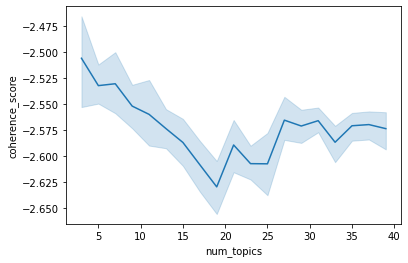

In [176]:
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling